So I'm writing my thesis and I want it to have a nice HTML version in addition to the mandatory-in-my-field latex PDF version. I've done some of the diagrams in SVG using Inkscape which is a nice tool for this kind of thing.

So how hard can it be? Turns out quite hard...

## On changing web standards

__Disclaimer:__ The web is an evolving thing, depending on when you read this some of what I saw here may already be out of date, or be partially fixed on some browsers some of the. This is your reminder to check the date of this post before trying to copy anything in here.

The first hurdle is how you embed your SVG files in your HTML. For thesis I have been using `img` tags inside `figure` tags like this

```html
<figure>
<img src="/path/to/image.svg" />
<figcaption aria-hidden="true">
Figure 3: Caption goes here!
</figcaption>
</figure>
```

Sadly it turns out that, while this works, it won't work for interactivity with js. This is because when the browser see an svg inside  essentially the browser renders the svg as a static image and displays it. This also means you can't select the text or other elements in the svg even though you should be able to!

So what's the alternative? Well if you google how to embed svgs you'll see that you have a few options: `object` tags, `svg` tags, `iframe` tags etc. I had a play around with a few of these options but because I am generating my HTML from markdown via pandoc, it's a little tricky to use entirely custom HTML. 

So I instead chose to stick with the `img` tags but use some js to dynamically replace them with `svg` tags when I wanted to add interactivity. So I use query for the image I want, use `d3.xml` to download the content of the `src` attribute, and then replace the `img` with the constructed `svg` tag.

```js
//grab the img tag containing our target svg
const img = document.querySelector("img#id-of-image");
	
if(img !== null) {
    d3.xml(img.getAttribute('src')) //download the svg
        .then(data => {
            const svg = data.documentElement;
            svg.setAttribute('width', '100%');
            svg.setAttribute('height', 'auto');
    
           d3.select(img).node().replaceWith(svg);
    });
}
```

it would probably be better if I could just make pandoc replace the `img` tags with `svg` tags statically, but reader, I couldn't make it work.

My target image looks like this 
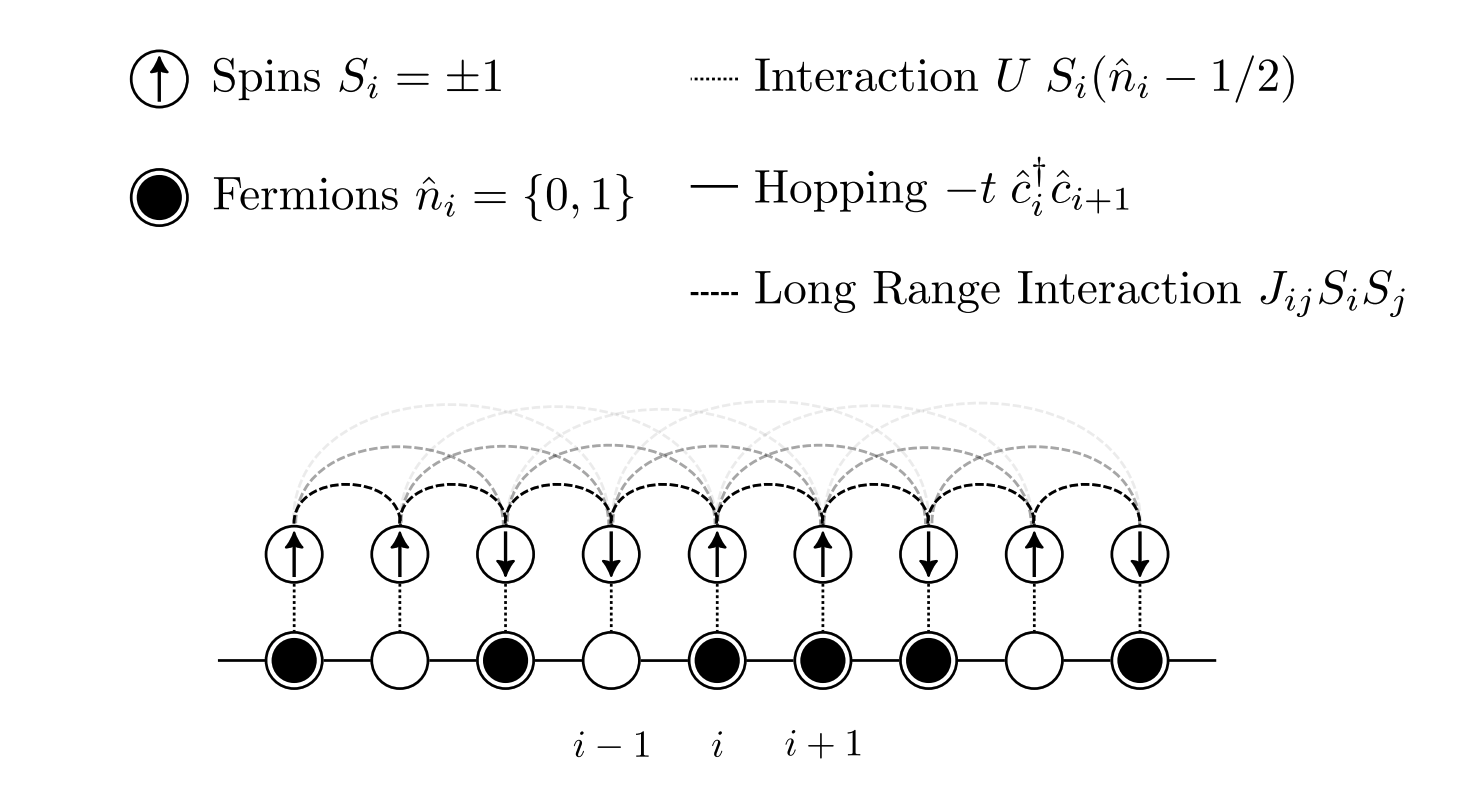

This diagram represents a model of a quantum system of _spins_ and _fermions_. The spins are the little arrows which can either be up or down and the fermions are the little circles which can either be filled or unfilled. I want to make both of them switch states when you click them.

## Fermions

First we need a way to select the fermions with d3, this is where the xml editor in inkscape comes in. With Edit > XML Editor you can add attributes to any svg element using the little "+" icon. I used this to add "class : fermion" to each of the fermion circles.

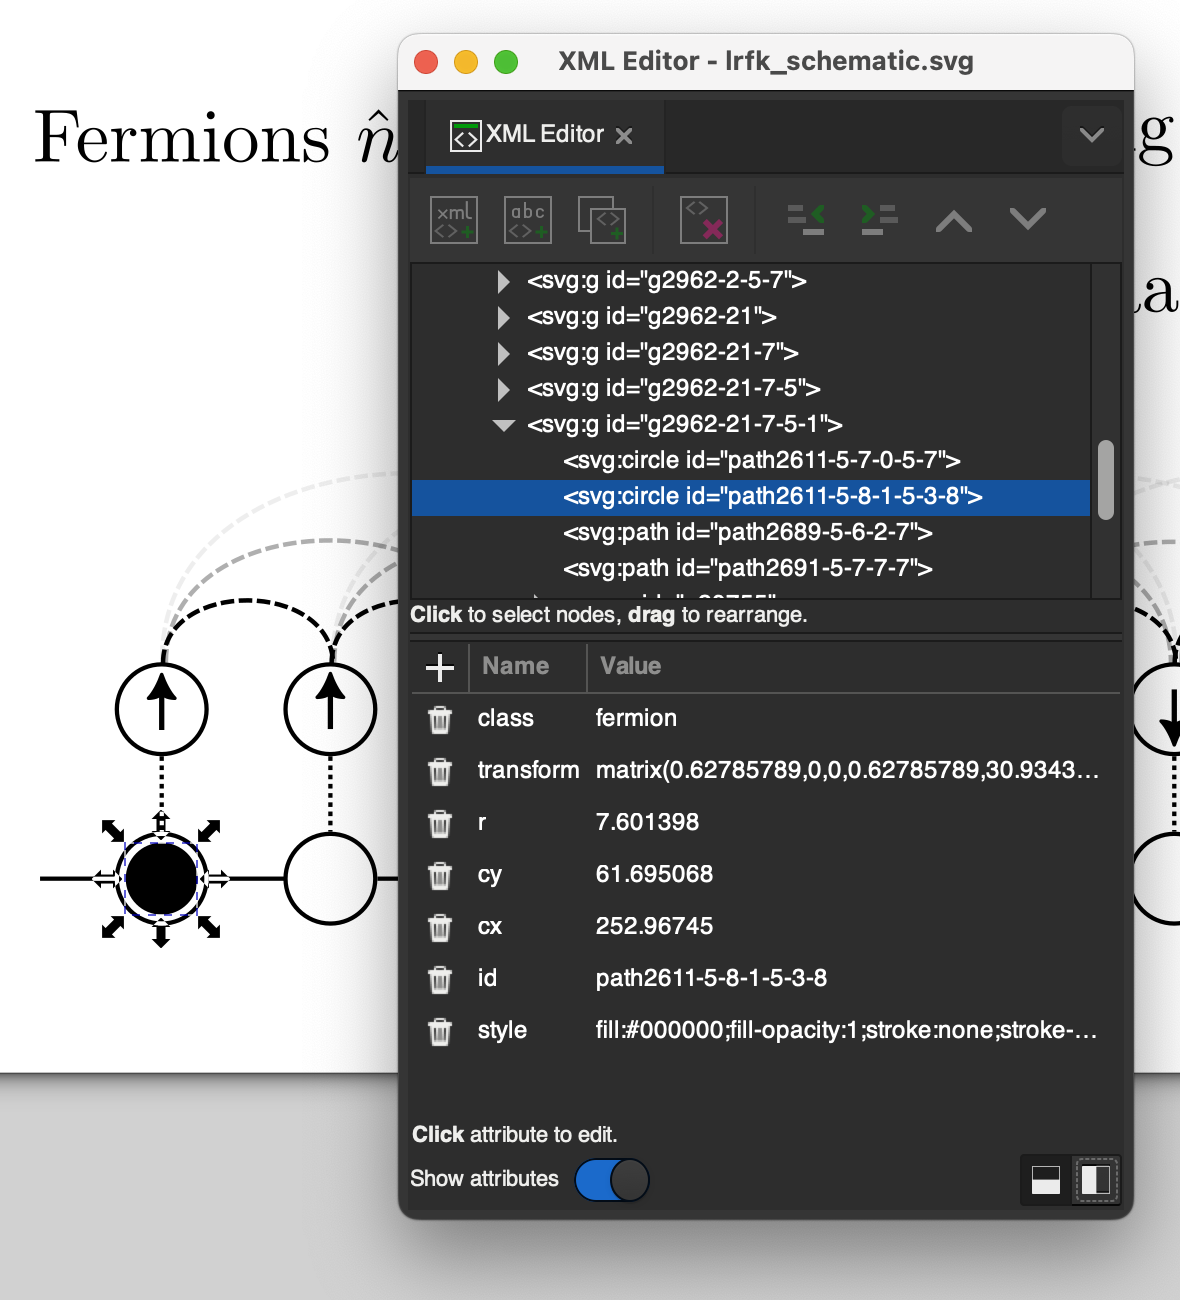


Now to animate them with d3, after a false start involving trying to figure out how to reliably compare colours in d3 I switched to using opacity and ended with with this code: 

```js
const fermions = d3.select(svg).selectAll(".fermion");
fermions.on("click", function() {
    d3.select(this)
        .transition()
        .duration(100)
        .style("fill-opacity" , d => {return d3.select(this).style("fill-opacity") === '1' ? 0 : 1});
}, true)
```

The trick here is that in d3 you can set attributes with a function and use `d3.select(this)` to get a handle on the current element. You can then do a query on the current value of the style and change it accordingly. Originally I had wanted to switch the fill colour between black and white but try as I might I could not find a way to reliably compare two colours together.

# Spins

Same deal for this spins, add a "class: spin" to them all using the XML editor. 

I had originally wanted them to rotate, but as far as I can tell this would require finding the geometric centre of each spin to rotate and that seems more trouble than it's worth. I had a go with "transform-origin: centre" but didn't get it to work. 

So I use a different hack, I switched when end of the line the arrow head is on:

```js
const spins = d3.select(svg).selectAll(".spin");
spins.attr("pointer-events", "all"); //this is the subject of the next paragraph!
spins.on("click", function() {
    const start = d3.select(this).select("path").style("marker-start");
    const end = d3.select(this).select("path").style("marker-end");
    const direction = (start === "none");
    const url =  direction ? end : start;

    d3.select(this).select("path")
        .transition()
        .duration(100)
        .style("marker-start", () => {return direction ? url : "none"})
        .style("marker-end", () => {return direction ? "none" : url})
}, true)
```

After this, I could make the spins flip but only if I clicked in a very tiny area near each spin, turns out the default was svg elements determine if you've clicked on them is a bit conservative, `spins.attr("pointer-events", "all");` fixes this.

And there we have it! Check out [the introduction of my thesis](/thesis/1_Introduction/1_Intro.html) to try it out.